<!-- # Main plots

> This notebook contains the plots of contextual fraction vs various physical quantities for two qutrit UDW detectors interacting with a quantum field. -->


In [1]:
'''This cell imports the necessary libraries and modules for the analysis.'''
import sys, os
from pathlib import Path

# Robustly ensure 'src' is on sys.path (works whether CWD is repo root or notebooks/)
for p in [Path.cwd(), *Path.cwd().parents]:
    cand = p / "src"
    if cand.exists():
        sys.path.insert(0, str(cand))
        break

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Importing modules
from qft.udw_qutrits import detector_state      
from optimization.lin_prog import contextual_fraction
from utils.state_checks import is_valid_state, validate_and_print


plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})


def reduce_state(rho: np.ndarray) -> np.ndarray:
    """
    Partial trace over the second qutrit (B) of a 2-qutrit density matrix.

    Parameters
    ----------
    rho : np.ndarray
        9x9 density matrix for a 2-qutrit system (A⊗B), dtype complex recommended.

    Returns
    -------
    np.ndarray
        3x3 reduced density matrix for the first qutrit (A).
    """
    rho = np.asarray(rho)
    if rho.shape != (9, 9):
        raise ValueError("rho must be a 9x9 matrix for a 2-qutrit system.")

    # Reshape to indices [i_A, i_B, j_A, j_B]
    rho_reshaped = rho.reshape(3, 3, 3, 3)

    # Trace over B: sum over i_B == j_B
    rho_A = np.trace(rho_reshaped, axis1=1, axis2=3)  # shape (3,3)

    return rho_A


# Product state: should return rho_A
rho_A_true = np.array([[1,0,0],[0,0,0],[0,0,0]], complex)
rho_B_true = np.array([[0,0,0],[0,1,0],[0,0,0]], complex)
# rho_B = np.eye(3)/3
rho_prod_1 = np.kron(rho_A_true, rho_B_true)
rho_prod_2 = np.kron(rho_B_true, rho_A_true)
assert np.allclose(reduce_state(rho_prod_1), rho_A_true)
assert np.allclose(reduce_state(rho_prod_2), rho_B_true)

# Maximally entangled |Φ⟩ = (|00⟩+|11⟩+|22⟩)/√3: reduced is I/3
phi = sum(np.kron(np.eye(3)[k], np.eye(3)[k]) for k in range(3))/np.sqrt(3)
rho_ME = np.outer(phi, phi.conj())
assert np.allclose(reduce_state(rho_ME), np.eye(3)/3)


## Contextual fraction vs gap*switching (fixed R)

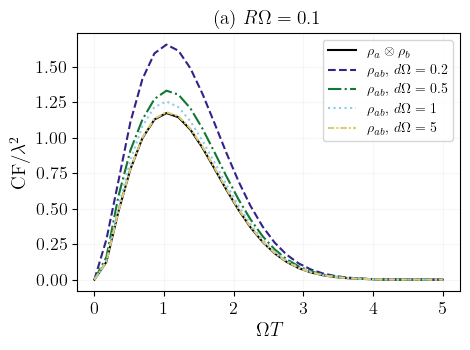

In [2]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 30)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
              # "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"(a) $R\Omega={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_different_models_final_final.pdf")
plt.show()


THIS WILL GO TO THE PAPER:

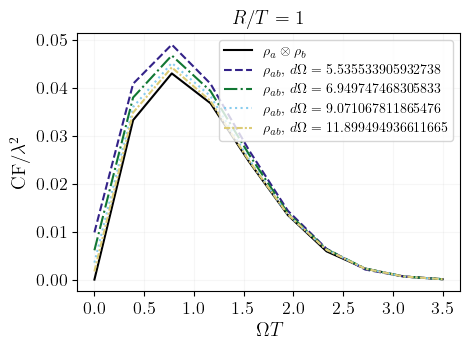

In [60]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 3.5, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()



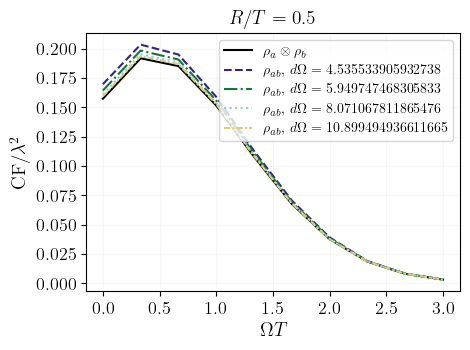

In [52]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.5
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 3, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

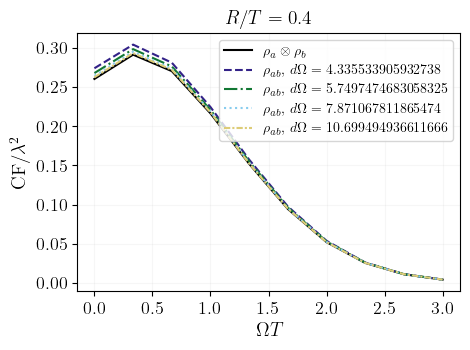

In [63]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.4
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 3, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

This goes to the paper:

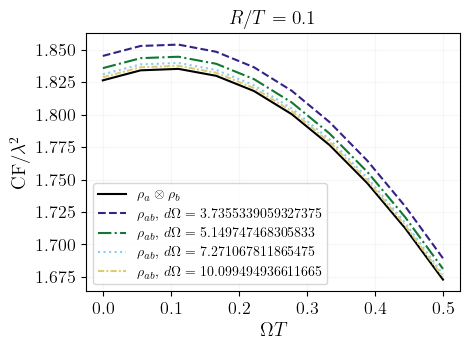

In [68]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 0.5, 10)  # avoid zero to keep numerics well-behaved
deez = [2*smearing+5/np.sqrt(2), 2*smearing+7/np.sqrt(2), 2*smearing+10/np.sqrt(2), 2*smearing+14/np.sqrt(2)]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

María's old version:

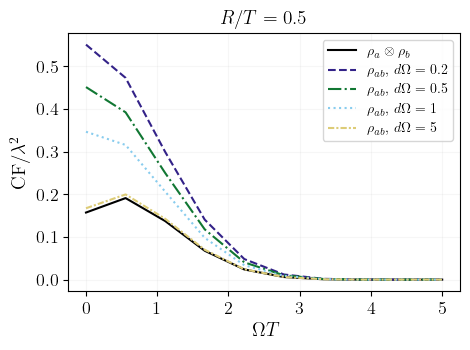

In [13]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.5
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 10)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    #     rho_final = rho
                    #     # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                    rho1 = reduce_state(rho)
                    # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                    rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
            #   "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    # if rho_type == "entangled":
                    rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    # elif rho_type == "product":
                        # rho1 = reduce_state(rho)
                        # rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        #rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R/T={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()


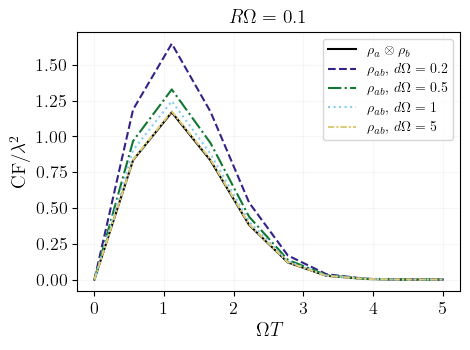

In [9]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
separation = 0
smearing = 0.1
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

# Sweep gaps
gaps = np.linspace(0.0, 5, 10)  # avoid zero to keep numerics well-behaved
deez = [0.2, 0.5, 1, 5]

plt.figure(figsize=(4.8,3.6))

rho_type = "product"
for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=0,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = r"$\rho_a \otimes \rho_b$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[0])

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1)), (0, (1, 1))]  # Add more if needed
rho_types = [
              # "product" ,
              "entangled"
        ]

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=smearing,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        # rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"$\rho_{{ab}}$, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle,color=colors[idx+1])



plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF/$\lambda^2$",fontsize=14)
plt.title(rf"$R\Omega={smearing}$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()


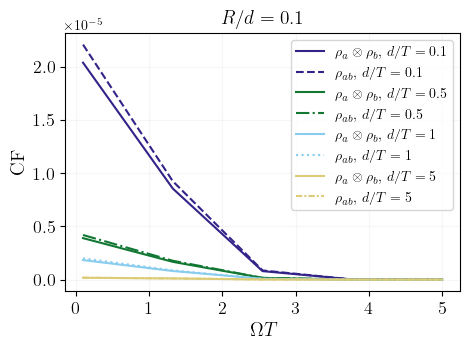

In [10]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

rho_types = [
              "product",
              "entangled"
        ]

rho_type_labels = {
    "product": r"$\rho_a\otimes\rho_b$",
    "entangled": r"$\rho_{{ab}}$"
}

# Sweep gaps
gaps = np.linspace(0.1, 5, 5)  # avoid zero to keep numerics well-behaved
deez = [0.1, 0.5, 1, 5]

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=gap,
                    switching=switching,
                    separation=d,
                    regulator=regulator,
                    smearing=0.1*d,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)
            label = rf"{rho_type_labels[rho_type]}, $d/T={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            color = colors[idx+1]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle, color=color)

plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF",fontsize=14)
plt.title(rf" $R/d=0.1$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
# plt.savefig("contextual_fraction_vs_gap_different_models.pdf")
plt.show()

Invalid state detected at gap = 0.8620689655172414

Matrix Validation Results:
✗ INVALID DENSITY MATRIX
Failed checks: not_positive_semidefinite

Detailed Analysis:
--------------------
Hermitian check ✓: Max deviation = 0.00e+00
Trace check ✓: Tr(ρ) = 1.000000+0.000000j, deviation = 1.11e-16
Positive semidefinite ✗: Min eigenvalue = -1.02e-10+0.00e+00j
All eigenvalues: [-1.01605474e-10+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  4.28713630e-08+0.j  9.99999957e-01+0.j]
Eigenvalue error: Minimum eigenvalue: -1.02e-10



ValueError: x and y must have same first dimension, but have shapes (30,) and (5,)

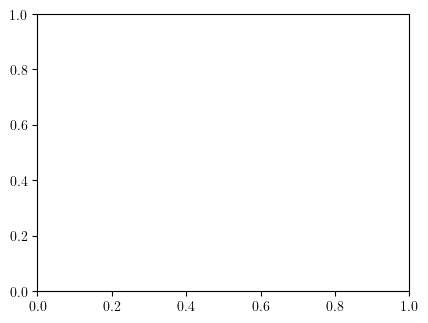

In [12]:
'''This cell generates the plots for contextual fraction vs gap for different detector types.'''


# Fixed parameters
switching = 1.0
lam = 1e-3
regulator = 1.0
regularization = "heaviside"  # used by Q_term but detector_type/group decide which terms contribute

colors = ["#000000","#332288","#117733","#88CCEE","#DDCC77", "#CC6677", "#AA4499","#882255"]

group_types = [
                # ("SU2", "point_like"), 
                ("SU2", "smeared"), 
                # ("HW", "smeared")
                ]
# labels = {
#     # ("SU2", "point_like"): "SU(2), point like",
#     ("SU2", "smeared"): "SU(2), smeared",
#     # ("HW", "smeared"): "HW, smeared"
# }

plt.figure(figsize=(4.8,3.6))

rho_types = [
              "product",
              "entangled"
        ]

rho_type_labels = {
    "product": r"$\rho_a\otimes\rho_b$",
    "entangled": r"$\rho_{{ab}}$"
}

# Sweep gaps
gaps = np.linspace(0.0, 5, 30)  # avoid zero to keep numerics well-behaved
deez = [0.1, 0.5, 1, 5]

linestyles = [ "--", "-.", ":", (0, (3, 1, 1, 1))]  # Add more if needed

for idx, d in enumerate(deez): 
    linestyle = linestyles[idx % len(linestyles)]
    for rho_type in rho_types:
        for group, detector_type in group_types:
            cf_vals = []
            for gap in gaps:
                rho = detector_state(
                    gap=switching,
                    switching=gap,
                    separation=d,
                    regulator=regulator,
                    smearing=0.05*d,
                    regularization=regularization,
                    detector_type=detector_type,
                    group=group,
                    lam=lam,
                )
                if is_valid_state(rho):
                    if rho_type == "entangled":
                        rho_final = rho
                        # rho_final = np.kron(rho1, rho1)
                    elif rho_type == "product":
                        rho1 = reduce_state(rho)
                        #rho_final = np.kron(rho1, np.eye(3)*(1/3))
                        rho_final = np.kron(rho1, rho1)
                    
                    res = contextual_fraction(rho_final) 

                    if not res.get("success", False):
                        cf_vals.append(np.nan)
                    else:
                        cf_vals.append(res.get("b", np.nan))
                else:
                    print("Invalid state detected at gap =", gap)
                    validate_and_print(rho)
                    break

            cf_vals = np.array(cf_vals)/(lam**2)
            label = rf"{rho_type_labels[rho_type]}, $d\Omega={d}$"
            linestyle = "-" if rho_type == "product" else linestyles[idx % len(linestyles)]
            color = colors[idx+1]
            plt.plot(gaps, cf_vals, lw=1.5, label=label, linestyle=linestyle, color=color)

plt.xlabel(r"$\Omega T$",fontsize=14)
plt.ylabel(r"CF$/\lambda^2$",fontsize=14)
plt.title(rf"(b) $R/d=0.01$",fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.savefig("contextual_fraction_vs_gap_different_models_final_final_smearing_d_3.pdf")
plt.show()